
Sine: 1D


In [1]:
pip install pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Sine'
n_test = 50
eps = 1e-08

util_grad_exact = 'dEI_GP'
util_grad_approx = 'ExpectedImprovement'

n_init = 2 # random initialisations
iters = 2
opt = True

In [4]:
### Objective Function - Sine(x) 1-D:

def objfunc(x1_training):
    return operator * np.sin(x1_training)
    
# Constraints:
lb = 0 
ub = 2 * np.pi
    
# Input array dimension(s):
dim = 1

# 1-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub])
             }

# True y bounds:
operator = 1
y_global_orig = 1 # targets global maximum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
  
x_test = np.column_stack((x1_test))


In [5]:
n_start_AcqFunc = n_test


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: Multistart changed to variable 'n_start_AcqFunc'

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        if self.n_jobs == 1:
            for index, start_point in enumerate(start_points_arr):
                res = minimize(self._acqWrapper, x0=start_point, method=method,
                               bounds=self.parameter_range)
                x_best[index], f_best[index] = res.x, np.atleast_1d(res.fun)[0]
        else:
            opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
            x_best = np.array([res.x for res in opt])
            f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr


In [10]:
## dGPGO:

grad = 0

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1632136166.1046212

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
1      	 [3.51035172]. 	  -0.36045819878289775 	 0.4980652197092493
2      	 [1.74763472]. 	  0.9844047963369247 	 0.9844047963369247


In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.73943676]. 	  0.39140314238622503 	 0.39140314238622503
init   	 [0.16289932]. 	  0.1621798196991543 	 0.39140314238622503
1      	 [1.94305327]. 	  0.9315088262495432 	 0.9315088262495432
2      	 [1.64090893]. 	  0.9975431178098604 	 0.9975431178098604


In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.46076529]. 	  -0.31378108896593276 	 -0.31378108896593276
init   	 [4.44942399]. 	  -0.9656234911816226 	 -0.31378108896593276
1      	 [1.9236075]. 	  0.9384050566628966 	 0.9384050566628966
2      	 [1.10998428]. 	  0.8956916959491921 	 0.9384050566628966


In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.07602768]. 	  -0.20567913683943348 	 -0.20567913683943348
init   	 [3.43836163]. 	  -0.29243195249626 	 -0.20567913683943348
1      	 [0.]. 	  0.0 	 0.0   
2      	 [1.21360114]. 	  0.936881203001194 	 0.936881203001194


In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.39482423]. 	  0.9845568238544921 	 0.9845568238544921
init   	 [5.47097243]. 	  -0.7258111732893464 	 0.9845568238544921
1      	 [1.39482396]. 	  0.9845567759471279 	 0.9845568238544921
2      	 [0.87067246]. 	  0.7647623871900141 	 0.9845568238544921


In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.61000578]. 	  -0.6234750224283673 	 0.8702462683756358
init   	 [2.08589063]. 	  0.8702462683756358 	 0.8702462683756358
1      	 [1.91096417]. 	  0.9426986803335883 	 0.9426986803335883
2      	 [1.08203532]. 	  0.8829152817863003 	 0.9426986803335883


In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.47945912]. 	  0.46129935252013665 	 0.46129935252013665
init   	 [4.9003743]. 	  -0.9823827329358714 	 0.46129935252013665
1      	 [0.47945881]. 	  0.46129907926920427 	 0.46129935252013665
2      	 [1.02143055]. 	  0.8528558488389196 	 0.8528558488389196


In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.48791879]. 	  -0.7140502171640402 	 -0.19638018397327808
init   	 [6.08552046]. 	  -0.19638018397327808 	 -0.19638018397327808
1      	 [0.05574621]. 	  0.055717345717530925 	 0.055717345717530925
2      	 [1.04886626]. 	  0.8668585516333727 	 0.8668585516333727


In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.06518273]. 	  0.06513658313446964 	 0.06513658313446964
init   	 [3.15337106]. 	  -0.011778137509490022 	 0.06513658313446964
1      	 [0.06518301]. 	  0.06513686170811389 	 0.06513686170811389
2      	 [0.37262402]. 	  0.36406063420106793 	 0.36406063420106793


In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.84635053]. 	  -0.9910405618689735 	 0.1300191992631183
init   	 [0.13038834]. 	  0.1300191992631183 	 0.1300191992631183
1      	 [0.24677898]. 	  0.24428179395115263 	 0.24428179395115263
2      	 [0.99324796]. 	  0.8378036902093283 	 0.8378036902093283


In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.13266786]. 	  0.9055472383029711 	 0.9055472383029711
init   	 [0.12236655]. 	  0.12206140230558486 	 0.9055472383029711
1      	 [1.56192024]. 	  0.999960607843687 	 0.999960607843687
2      	 [2.95135961]. 	  0.1890877372260505 	 0.999960607843687


In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.96863371]. 	  0.824112578376373 	 0.824112578376373
init   	 [4.64986938]. 	  -0.9980462862647542 	 0.824112578376373
1      	 [0.7191714]. 	  0.6587614993561814 	 0.824112578376373
2      	 [1.76344173]. 	  0.9815011916204144 	 0.9815011916204144


In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.88644836]. 	  -0.984889873008369 	 0.9969376206633884
init   	 [1.4925155]. 	  0.9969376206633884 	 0.9969376206633884
1      	 [1.49325505]. 	  0.9969951809220321 	 0.9969951809220321
2      	 [0.58766588]. 	  0.5544199951209234 	 0.9969951809220321


In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.22920127]. 	  -0.08749658578076804 	 -0.08749658578076804
init   	 [4.8579393]. 	  -0.9894262397103321 	 -0.08749658578076804
1      	 [1.53881166]. 	  0.999488534249255 	 0.999488534249255
2      	 [0.74609076]. 	  0.6787732083105645 	 0.999488534249255


In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.33327888]. 	  -0.8133610692020243 	 0.9018516274702986
init   	 [1.12403625]. 	  0.9018516274702986 	 0.9018516274702986
1      	 [1.12410993]. 	  0.9018834575475518 	 0.9018834575475518
2      	 [1.9016555]. 	  0.9457635837737034 	 0.9457635837737034


In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.40297923]. 	  0.9859517267469423 	 0.9859517267469423
init   	 [3.28713222]. 	  -0.145026312745253 	 0.9859517267469423
1      	 [1.34728885]. 	  0.9751260115914113 	 0.9859517267469423
2      	 [6.28318531]. 	  -2.4492935982947064e-16 	 0.9859517267469423


In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.85143482]. 	  0.9608787924880139 	 0.9608787924880139
init   	 [3.33377491]. 	  -0.191001425675173 	 0.9608787924880139
1      	 [1.85128929]. 	  0.9609190886605792 	 0.9609190886605792
2      	 [1.521867]. 	  0.9988031992928643 	 0.9988031992928643


In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.08642188]. 	  -0.8103968924772864 	 -0.034257853344941754
init   	 [3.17585721]. 	  -0.034257853344941754 	 -0.034257853344941754
1      	 [0.]. 	  0.0 	 0.0   
2      	 [1.18282987]. 	  0.9256802781839758 	 0.9256802781839758


In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.61282169]. 	  0.5751779719191328 	 0.5751779719191328
init   	 [4.78307303]. 	  -0.9975029221437467 	 0.5751779719191328
1      	 [0.73291081]. 	  0.6690358648568024 	 0.6690358648568024
2      	 [1.55210033]. 	  0.9998252348514436 	 0.9998252348514436


In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.69533481]. 	  -0.525873840130537 	 -0.525873840130537
init   	 [5.64050171]. 	  -0.5993457940835627 	 -0.525873840130537
1      	 [0.]. 	  0.0 	 0.0   
2      	 [1.39742658]. 	  0.985009069762252 	 0.985009069762252


In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1632136184.58629

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.62022653]. 	  0.4980652197092493 	 0.4980652197092493
init   	 [4.52593227]. 	  -0.9826672516685445 	 0.4980652197092493
1      	 [3.51035172]. 	  -0.36045819878289775 	 0.4980652197092493
2      	 [1.75416279]. 	  0.9832354224792772 	 0.9832354224792772


In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.73943676]. 	  0.39140314238622503 	 0.39140314238622503
init   	 [0.16289932]. 	  0.1621798196991543 	 0.39140314238622503
1      	 [1.84111926]. 	  0.9636847083859358 	 0.9636847083859358
2      	 [1.65736938]. 	  0.9962548932456193 	 0.9962548932456193


In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.46076529]. 	  -0.31378108896593276 	 -0.31378108896593276
init   	 [4.44942399]. 	  -0.9656234911816226 	 -0.31378108896593276
1      	 [1.92493885]. 	  0.9379441963814197 	 0.9379441963814197
2      	 [1.11346451]. 	  0.897233841631879 	 0.9379441963814197


In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.07602768]. 	  -0.20567913683943348 	 -0.20567913683943348
init   	 [3.43836163]. 	  -0.29243195249626 	 -0.20567913683943348
1      	 [0.27746583]. 	  0.27391928319888903 	 0.27391928319888903
2      	 [0.93447829]. 	  0.8042891689922342 	 0.8042891689922342


In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.39482423]. 	  0.9845568238544921 	 0.9845568238544921
init   	 [5.47097243]. 	  -0.7258111732893464 	 0.9845568238544921
1      	 [1.2852604]. 	  0.9595108360275852 	 0.9845568238544921
2      	 [2.56156498]. 	  0.548047084195927 	 0.9845568238544921


In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.61000578]. 	  -0.6234750224283673 	 0.8702462683756358
init   	 [2.08589063]. 	  0.8702462683756358 	 0.8702462683756358
1      	 [2.21048597]. 	  0.8022810637441707 	 0.8702462683756358
2      	 [1.28505753]. 	  0.9594536721756787 	 0.9594536721756787


In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.47945912]. 	  0.46129935252013665 	 0.46129935252013665
init   	 [4.9003743]. 	  -0.9823827329358714 	 0.46129935252013665
1      	 [0.57970142]. 	  0.5477741578608659 	 0.5477741578608659
2      	 [1.4079276]. 	  0.986766181246236 	 0.986766181246236


In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.48791879]. 	  -0.7140502171640402 	 -0.19638018397327808
init   	 [6.08552046]. 	  -0.19638018397327808 	 -0.19638018397327808
1      	 [0.05574621]. 	  0.055717345717530925 	 0.055717345717530925
2      	 [1.00718639]. 	  0.845332046832957 	 0.845332046832957


In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.06518273]. 	  0.06513658313446964 	 0.06513658313446964
init   	 [3.15337106]. 	  -0.011778137509490022 	 0.06513658313446964
1      	 [0.14367728]. 	  0.14318346846681237 	 0.14318346846681237
2      	 [0.23856763]. 	  0.23631106371863486 	 0.23631106371863486


In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.84635053]. 	  -0.9910405618689735 	 0.1300191992631183
init   	 [0.13038834]. 	  0.1300191992631183 	 0.1300191992631183
1      	 [0.24681462]. 	  0.2443163576545763 	 0.2443163576545763
2      	 [1.00024373]. 	  0.8416026458341673 	 0.8416026458341673


In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.13266786]. 	  0.9055472383029711 	 0.9055472383029711
init   	 [0.12236655]. 	  0.12206140230558486 	 0.9055472383029711
1      	 [1.50717706]. 	  0.9979769768537794 	 0.9979769768537794
2      	 [2.81342918]. 	  0.3223050551384021 	 0.9979769768537794


In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.96863371]. 	  0.824112578376373 	 0.824112578376373
init   	 [4.64986938]. 	  -0.9980462862647542 	 0.824112578376373
1      	 [0.71378066]. 	  0.6546962104331061 	 0.824112578376373
2      	 [1.82288989]. 	  0.9683923430737819 	 0.9683923430737819


In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.88644836]. 	  -0.984889873008369 	 0.9969376206633884
init   	 [1.4925155]. 	  0.9969376206633884 	 0.9969376206633884
1      	 [1.49325505]. 	  0.9969951809220321 	 0.9969951809220321
2      	 [0.55451335]. 	  0.5265296303879659 	 0.9969951809220321


In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.22920127]. 	  -0.08749658578076804 	 -0.08749658578076804
init   	 [4.8579393]. 	  -0.9894262397103321 	 -0.08749658578076804
1      	 [1.54972147]. 	  0.9997779333655235 	 0.9997779333655235
2      	 [0.83619176]. 	  0.7420958653188517 	 0.9997779333655235


In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.33327888]. 	  -0.8133610692020243 	 0.9018516274702986
init   	 [1.12403625]. 	  0.9018516274702986 	 0.9018516274702986
1      	 [1.22789038]. 	  0.9417815898742847 	 0.9417815898742847
2      	 [2.07354656]. 	  0.8762607110375408 	 0.9417815898742847


In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.40297923]. 	  0.9859517267469423 	 0.9859517267469423
init   	 [3.28713222]. 	  -0.145026312745253 	 0.9859517267469423
1      	 [1.45905294]. 	  0.9937632013847422 	 0.9937632013847422
2      	 [6.14206193]. 	  -0.1406554154993008 	 0.9937632013847422


In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.85143482]. 	  0.9608787924880139 	 0.9608787924880139
init   	 [3.33377491]. 	  -0.191001425675173 	 0.9608787924880139
1      	 [1.83668411]. 	  0.9648596027658545 	 0.9648596027658545
2      	 [0.50360571]. 	  0.48258672204429637 	 0.9648596027658545


In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.08642188]. 	  -0.8103968924772864 	 -0.034257853344941754
init   	 [3.17585721]. 	  -0.034257853344941754 	 -0.034257853344941754
1      	 [0.06921994]. 	  0.06916467175497397 	 0.06916467175497397
2      	 [0.07319366]. 	  0.07312832161543911 	 0.07312832161543911


In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.61282169]. 	  0.5751779719191328 	 0.5751779719191328
init   	 [4.78307303]. 	  -0.9975029221437467 	 0.5751779719191328
1      	 [0.4808934]. 	  0.46257143143959506 	 0.5751779719191328
2      	 [1.29349563]. 	  0.9617979039604797 	 0.9617979039604797


In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.69533481]. 	  -0.525873840130537 	 -0.525873840130537
init   	 [5.64050171]. 	  -0.5993457940835627 	 -0.525873840130537
1      	 [0.23300446]. 	  0.23090182793061037 	 0.23090182793061037
2      	 [1.19239731]. 	  0.9292572816852617 	 0.9292572816852617


In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

11.6785569190979

In [55]:
time_approx, time_exact


(18.481553554534912, 11.6785569190979)

In [56]:
def plot_sine(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std # z-score, 95% confidence (two-tail)
    colours = ['Post', 'Random']
    if new:
        plt.figure(figsize=[7,5])
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Post-initialization ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialization ($\mathbf{x}$, $y$)')
        plt.ylim(-1.75, 1.75)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), y_hat, color = 'Yellow', label='$\hat{\mu}_{GP}(\mathbf{x})$')
        plt.plot(x_test.flatten(), np.sin(x_test.flatten()), color = 'Orange', label='True function: y = sin($\mathbf{x}$)')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% C.I. for $\mu_{GP}(\mathbf{x})$')
        title = 'Sine: 50 random GP EI samples'
        plt.title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$)")
        plt.legend(loc=3)
        plt.show()


In [57]:
def plot_dGPGO(dGPGO, param, new):
    fig, ax = plt.subplots(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    a = np.array([-dGPGO.acqfunc(np.atleast_1d(x))[0] for x in x_test]).flatten()
    plt.plot(x_test, a, color='r', label='GP EI$(\mathbf{x})$: Best GP EI Random Sample')
    plt.ylim(min(a)-0.01, max(a)+0.01)
    plt.xlim(0, 2 * np.pi)
    plt.axvline(x_test[np.argmax(a)], color='b', ls = '--', label='GP EI Max: next $\mathbf{x}$')
    plt.legend(loc=1)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP EI$(\mathbf{x})$")
    title = 'GP EI: 50 random samples'
    plt.suptitle(title, weight = 'bold')
    plt.draw()
    plt.show()


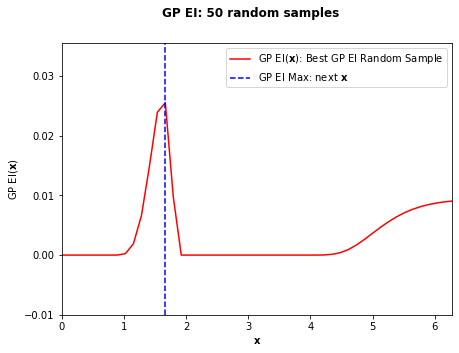

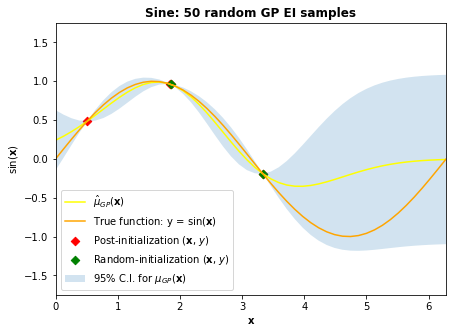

In [58]:
plot_dGPGO(exact_17, param, new=True)
plot_sine(exact_17, param, new=True)


In [59]:
def plot_GPGO_multi(GPGO_multi, param, new):
    fig, ax = plt.subplots(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    a = np.array([-GPGO_multi._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
    plt.plot(x_test, a, color='y', label='GP EI$(\mathbf{x})$: L-BFGS-B')
    plt.ylim(min(a)-0.01, max(a)+0.01)
    plt.xlim(0, 2 * np.pi)
    plt.axvline(x_test[np.argmax(a)], color='b', ls = '--', label='GP EI Max: next $\mathbf{x}$')
    plt.legend(loc=1)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP EI$(\mathbf{x})$")
    title = 'GP EI: 50 random samples'
    plt.suptitle(title, weight = 'bold')
    plt.draw()
    plt.show()


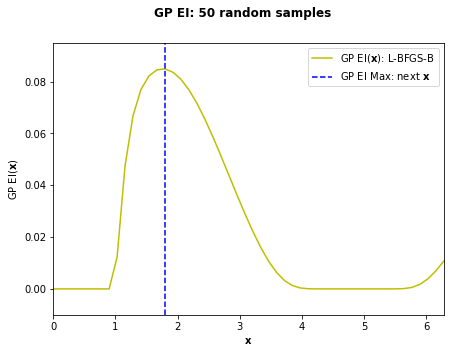

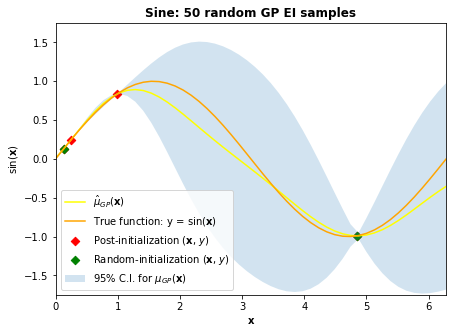

In [60]:
plot_GPGO_multi(approx_10, param, new=True)
plot_sine(approx_10, param, new=True)


In [61]:
x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
a = np.array([-approx_10._acqWrapper(np.atleast_1d(x))[0] for x in x_test]).flatten()
np.round(x_test[np.argmax(a)][0], 4)


1.7952

In [62]:
x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
a_exact = np.round(np.array([-exact_17.acqfunc(np.atleast_1d(x))[0] for x in x_test]).flatten(), 2)
np.round(x_test[np.argmax(a_exact)][0], 4)


1.667

In [63]:
np.max(a), np.max(a_exact)


(0.08491397253577262, 0.03)